# Artificial Neural Networks From Scratch

In [35]:
%matplotlib inline

In [52]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *

from scipy import optimize

import time
import shutil
import zipfile
import os
from mpl_toolkits.mplot3d import Axes3D


from urllib import urlretrieve
from datetime import datetime
from IPython.display import *

np.set_printoptions(precision=4)
np.set_printoptions(threshold=5)
np.set_printoptions(suppress=True)

pd.set_option('precision', 3, 'notebook_repr_html', True)

plt.rcParams['figure.figsize'] = 12, 8

# Get The Data

Download the necessary data from the UCI repository.

In [53]:
def get_dataset(url, data='data'):
    """
    Get's the data set necessary to train the ANN.
    """
    filename = url.rsplit("/")[-1]
    
    if not os.path.isdir(data): os.mkdir(data)

    urlretrieve(url, filename)

    compressed = zipfile.ZipFile(filename)
    compressed.extractall(data)
    compressed.close()
    
    os.remove(filename)

In [54]:
data = 'data'
url  = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip'

get_dataset(url, data)

In [55]:
df = pd.read_table('data/student-mat.csv', sep=';', index_col=None)

df.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,10,15,15,15
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,12,12,11
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,6,6,5,6
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,16,18,19
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,14,15,15


# Artificial Neural Network Implementation

## Single Layer Perceptron

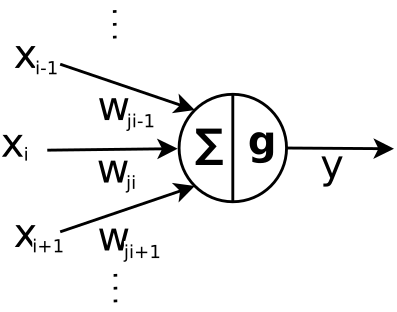

In [56]:
SVG(filename='img/neuron.svg')

In each layer

$a_j = \sum_i w_{ji} x_i$
$y_j = g(a_j)$

where

* $y_j$ is the $j$th output
* $x_i$ is the $i$th input
* $w_{ji}$ is the weight
* $a_{j}$ is called activation
* $g$ is the activation function, e.g. $\tanh$ in the hidden layers and the identity in the last layer (for regression)



# Multi Layer Perceptron

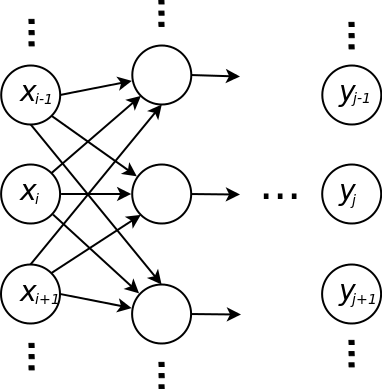

In [57]:
Image('img/net.png')

## Error function

$E = \frac{1}{2} \sum_n \sum_j \left( y_j^{(n)} - t_j^{(n)} \right)^2$

In each layer (we will omit the sample index $n$)

$$\delta_j = \begin{cases}y_j - t_j & \text{in the output layer}\\\\ g'(a_j) \sum_k \frac{\partial E}{\partial y_k} & \text{otherwise}\end{cases},$$

$$\frac{\partial E}{\partial w_{ji}} = \delta_j x_i$$

$$\frac{\partial E}{\partial x_i} = \delta_j w_{ji}$$

where

* all nodes $k$ are in the layer after $j$
* $a_j$ is known from fprop: $\sum_i w_{ji} x_i$
* actually you do not have to save $a_j$ because $g'(a_j)$ usually can be computed from $y_j$, e.g.
    * identity function: $g'(a_j) = 1$
    * $\tanh$: $g'(a_j) = 1 - y_j^2$
* $\frac{\partial E^{(n)}}{\partial w_{ji}}$ will be used to update the weight $w_{ji}$ in gradient descent
* $\frac{\partial E^{(n)}}{\partial x_i}$ will be passed to the previous layer to compute the deltas

**Do not forget to sum up the gradient with respect to the weights for each training example!**

In [58]:
class NeuralNet:
    
    def __init__(self):
        """
        Define Hyperparameters and weights.
        """
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        """
        Propogate inputs though network
        """
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        """
        Apply sigmoid activation function to scalar, vector, or matrix
        """
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        """
        Gradient of sigmoid
        """
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        """
        Compute cost for given X,y, use weights already stored in class.
        """
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        """
        Compute derivative with respect to W and W2 for a given X and y:
        """
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    def getParams(self):
        """
        Get W1 and W2 unrolled into vector:
        """
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        """
        Set W1 and W2 using single paramater vector.
        """
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

# Seperate Training and Testing Set

In [59]:
def assign_to_set(df):
    samples = np.random.choice(df.index,
                               size=np.int64(np.ceil(df.index.size * 0.2)),
                               replace=False,
    )
    testing  = df.ix[df.index[[samples]]]
    training = df[df.index != df.index.isin(testing.index)]
    return testing, training

In [60]:
testing, training = assign_to_set(df)

training.to_csv('data/student_math_training.csv')
testing.to_csv('data/student_math_test.csv')

# Double Check Gradient

In [61]:
def computeNumericalGradient(N, X, y):
    paramsInitial = N.getParams()
    numgrad = np.zeros(paramsInitial.shape)
    perturb = np.zeros(paramsInitial.shape)
    e = 1e-4

    for p in range(len(paramsInitial)):
        #Set perturbation vector
        perturb[p] = e
        N.setParams(paramsInitial + perturb)
        loss2 = N.costFunction(X, y)

        N.setParams(paramsInitial - perturb)
        loss1 = N.costFunction(X, y)

        #Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e)

        #Return the value we changed to zero:
        perturb[p] = 0

        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad 

# Instantiate and Set Data

In [62]:
class Trainer:
    
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

#Plot projections of our new data:

# Distribution

In [63]:
trainX = np.array(training[['goout', 'studytime']])
trainY = np.array(training[['G1']]) * 5

testX = np.array(testing[['goout', 'studytime']])
testY = np.array(testing[['G1']]) * 5

In [64]:
fig = plt.figure(0,(8,3))

plt.subplot(1,2,1)
plt.scatter(trainX[:,0], trainY)
plt.grid(1)
plt.xlabel('Hours Studying')
plt.ylabel('Test Score')

plt.subplot(1,2,2)
plt.scatter(trainX[:,1], trainY)
plt.grid(1)
plt.xlabel('Hours Outside')
plt.ylabel('Test Score')

py.iplot_mpl(fig, fileopt='overwrite', filename='nn-dataview')

Uh oh, an error occured on the server. 


PlotlyAccountError: Uh oh, an error occured on the server. 

#Normalize

# Train network with new data:

In [ ]:
NN = NeuralNet()
T  = Trainer(NN)

T.train(trainX, trainY)

hoursSleep = np.linspace(0, 10, 100)
hoursStudy = np.linspace(0, 5, 100)

hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

a, b  = np.meshgrid(hoursSleepNorm, hoursStudyNorm)

allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()


allOutputs = NN.forward(allInputs)

yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = plt.contour(xx,yy,100*allOutputs.reshape(100, 100))

plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('Hours Go Out')
plt.ylabel('Hours Studying')

fig = plt.figure()

ax = fig.gca(projection='3d')

surf = ax.plot_surface(
    xx, yy,
    100*allOutputs.reshape(100, 100),
    cmap=plt.cm.jet,
)

ax.set_xlabel('Hours Go Out')
ax.set_ylabel('Hours Studying')
ax.set_zlabel('Test Score')

plt.show()

py.iplot(
    Data([Surface(x=xx, y=yy,z=100*allOutputs.reshape(100, 100))]),
    fileopt='overwrite'
    filename='nn-gradient'
)

In [65]:
py.get_credentials()

{u'api_key': u'k7obdme0ak',
 u'stream_ids': [u'v2haf0lcy4', u'62wtxtzz5g', u'p34ps01hoo'],
 u'username': u'jjangsangy'}